In [2]:
osi_threshold = 0.4
dsi_threshold = 0.3
#tf_for_dsi_calc = 2.0
# ecid = 511510650
# ecid,eid pairs
eids = [(701412138, 704298735), (701412138, 705412356), (701412138, 704826374)]

# First pairs that I've tried
# [(511510650,501836392), (511510650,501886692), (511510650,501717543)]

# 'VISp', 175, 'Emx1-IRES-Cre', all pairs.
"""
[(543677425, 545446482),
 (517328083, 526928092),
 (517328083, 526504941),
 (536323956, 539515366),
 (536323956, 541048140),
 (536323956, 540684467),
 (543677425, 544507627),
 (543677425, 543677427),
 (517328083, 527583578)]
"""

# 'VISp', 175, 'Cux2-CreERT2', all pairs.
"""
[(701412138, 704298735),
 (511507650, 501794235),
 (511509529, 500964514),
 (511510718, 510174759),
 (511510855, 509644421),
 (511510718, 510514474),
 (511510736, 501704220),
 (511510670, 502205092),
 (511510650, 501886692),
 (511510670, 504642019),
 (511510736, 501559087),
 (511509529, 501271265),
 (511507650, 500855614),
 (511510650, 501836392),
 (511510855, 510517131),
 (511510736, 501474098),
 (511510855, 510705057),
 (511510718, 510345479),
 (701412138, 705412356),
 (511507650, 502115959),
 (701412138, 704826374),
 (511510650, 501717543),
 (511509529, 501337989),
 (511510670, 502368172)]
"""

# 'VISp', 175, 'Cux2-CreERT2'
# [(701412138, 704298735), (701412138, 705412356), (701412138, 704826374)]

# 'VISp', 175, 'Emx1-IRES-Cre'
# [(543677425, 545446482), (543677425, 544507627), (543677425, 543677427)]

# 'VISp', 175, 'Vip-IRES-Cre'
# [(604866830, 605913519), (604866830, 606353987), (604866830, 604866832)]

# 'VISp', 275, 'Cux2-CreERT2'
# [(511510699, 502974807), (511510699, 502810282), (511510699, 502608215)]

# VISp 275 Emx1-IRES-Cre
# [(527676429, 528402271), (527676429, 528693630), (527676429, 528574532)]

# 'VISp', 275, 'Vip-IRES-Cre'
# [(659491615, 663479824), (659491615, 663868423), (659491615, 661771052)]

# 'VISp', 275, 'Sst-IRES-Cre'
# [(601259497, 601259499), (601259497, 601338233), (601259497, 601423209)]

# 'VISp', 375, 'Emx1-IRES-Cre'
# [(545578995, 546716391), (545578995, 546341286), (545578995, 545578997)]

# 'VISp', 375, 'Sst-IRES-Cre'
# [(582621871, 584533518), (582621871, 584196534), (582621871, 583130100)]

# Events or dff
use_events = True
# Only pairs that are closer than these frames will be considered.
# For reference, ko 2011 did 50um. Each 512 pixel field of view is 400 um. 64frames =50um.
max_d = 64
# So we don't cheat and reuse the same cell, since there are some segmentation errors.
# And, to reduce the confound of fluorescence affecting neighbors 
min_d = 5
# corr_type = TEMP_CORR_AVG, AVG_TEMP_CORR, NOISE_CORR
# Ho ko 2011 used TEMP_CORR_AVG for signal correlation.
# "Signal correlation was calculated as the correlation coefficient of the average responses to stimulus."
# Then, NOISE_CORR for noise correlation.
# "Noise correlation was found by subtracting the average response from the responses"
corr_type = 'TEMP_CORR_AVG'

In [3]:
import os
drive_path = '/media/stephen/Brain20191/allen-brain-observatory/visual-coding-2p/'
if not os.path.isdir(drive_path):
    drive_path = '/media/alihamodi/Brain2019/allen-brain-observatory/visual-coding-2p/'

import warnings; warnings.simplefilter('ignore');
from utils.polarplot import *
from utils.polardata import *
from utils.data_wrappers import *
import os
import pandas as pd
from allensdk.core.brain_observatory_cache import BrainObservatoryCache
import allensdk.brain_observatory.stimulus_info as stim_info
manifest_file = os.path.join(drive_path,'manifest.json')
boc = BrainObservatoryCache(manifest_file=manifest_file)

import warnings;
warnings.simplefilter('ignore');
cells = boc.get_cell_specimens()
cells = pd.DataFrame.from_records(cells)
    
# Outputs = [cell_specimen_id, experiment_container_id, pref_dir]
#pd.DataFrame(boc.get_ophys_experiments(experiment_container_ids=[ecid]))
0

0

In [4]:
def get_dir_pairs_to_corrs_one_exp(boc, cells, ecid, eid):
    print("Processing ecid {}, eid {}".format(ecid, eid))
    sg_response_filter = get_sg_response_filter_from_saskia()
    filtered_cells = get_filtered_cells(cells, sg_response_filter)
    filtered_cells = filtered_cells[filtered_cells.experiment_container_id==ecid]
    data_set = boc.get_ophys_experiment_data(eid)

    # Filter out based on tf-specific-dsi, rather than allen's global dsi
    # Also recalculate preferred direction using specific tf.
    """
    tf_specific_dsi_col = []
    tf_specific_pref_dir_col = []
    for index, row in filtered_cells.iterrows():
        polardata_for_this_cell = get_avg_normalized_response(
            data_set = data_set,
            cell_specimen_id = row.cell_specimen_id,
            temporal_frequency = tf_for_dsi_calc)
        if polardata_for_this_cell is None:
            # Put negative value so dsi selector will ignore this guy.
            new_dsi_cell = -1
        else:
            new_dsi_cell = get_new_dsi(polardata_for_this_cell.to_frame())
        tf_specific_dsi_col.append(new_dsi_cell)
        tf_specific_pref_dir_col.append(polardata_for_this_cell.argmax())
    filtered_cells['tf_specific_dsi'] = tf_specific_dsi_col
    filtered_cells['pref_dir'] = tf_specific_pref_dir_col
    """
    # TODO: recompute this manually at a specific phase.
    filtered_cells['pref_ori'] = filtered_cells['pref_ori_sg'] 
    # Ko 2011 uses both.
    # TODO: recompute the dsi and osi based on a fixed sf and tf
    filtered_cells = filtered_cells[filtered_cells.osi_sg > osi_threshold]
    filtered_cells = filtered_cells[filtered_cells.dsi_dg > dsi_threshold]

    dirs = [0.0, 30.0, 60.0, 90.0, 120.0, 150.0]

    angle_to_cell_groups = {}
    for d in dirs:
        angle_to_cell_groups[d] = filtered_cells[filtered_cells.pref_ori == d].cell_specimen_id.values
        print(d, angle_to_cell_groups[d])

    dir_pairs_to_corrs = {}
    for d1 in dirs:
        for d2 in dirs:
            if len(angle_to_cell_groups[d1]) == 0 or len(angle_to_cell_groups[d2]) == 0:
                continue
            corrs, num_group1, num_group2, best_pair, max_pair_corr = pairwise_dir_avg_temp_corr_one_exp(
                boc, eid,
                angle_to_cell_groups[d1],
                angle_to_cell_groups[d2],
                max_d,
                min_d,
                use_events,
                corr_type)
            if corrs is None:
                continue
            dir_pairs_to_corrs[(d1, d2)] = corrs
            print ("d1", d1,
                   "d2", d2,
                   "num_pairs", len(corrs),
                   "num_group1", num_group1,
                   "num_group2", num_group2,
                   "max corr val, best-pair", max_pair_corr, best_pair,
                "corrs", corrs)
    return dir_pairs_to_corrs

all_dir_pairs_to_corrs = {}
for ecid, eid in eids:
    dir_pairs_to_corrs = get_dir_pairs_to_corrs_one_exp(boc, cells, ecid, eid)
    for dir_pair, corrs in dir_pairs_to_corrs.items():
        if dir_pair not in all_dir_pairs_to_corrs:
            all_dir_pairs_to_corrs[dir_pair] = []
        all_dir_pairs_to_corrs[dir_pair].extend(corrs)

Processing ecid 701412138, eid 704298735
0.0 [729433328 729433925 729434139 729434571 729435448 729435463]
30.0 [729434030 729434652 729434756]
60.0 [729433884]
90.0 [729432992 729433364 729434018]
120.0 [729433843 729433999 729434637 729435435]
150.0 [729432524 729432553 729433987 729434188]
d1 0.0 d2 90.0 num_pairs 1 num_group1 6 num_group2 3 max corr val, best-pair -0.05338525517767956 (729433328, 729433364) corrs [-0.05338525517767956]
d1 0.0 d2 150.0 num_pairs 2 num_group1 6 num_group2 4 max corr val, best-pair 0.15033439910408697 (729433328, 729434188) corrs [0.15033439910408697, 0.051831344291516965]
d1 30.0 d2 30.0 num_pairs 4 num_group1 3 num_group2 3 max corr val, best-pair 0.0060162384700868585 (729434652, 729434756) corrs [-0.024287403493794813, -0.024287403493794813, 0.0060162384700868585, 0.0060162384700868585]
d1 30.0 d2 120.0 num_pairs 6 num_group1 3 num_group2 4 max corr val, best-pair 0.11400152197213487 (729434030, 729434637) corrs [0.10049885753382676, 0.11400152197

In [6]:
from scipy import stats
angle_dist_to_corrs = {}
for dir_pair, corrs in all_dir_pairs_to_corrs.items():
    hi = max(dir_pair[0],dir_pair[1])
    lo = min(dir_pair[0],dir_pair[1])
    angle_dist = hi-lo
    if angle_dist > 90:
        angle_dist = 180-angle_dist
    if angle_dist not in angle_dist_to_corrs:
        angle_dist_to_corrs[angle_dist] = []
    angle_dist_to_corrs[angle_dist].extend(corrs)


90.0 -0.05630427214206994 0.19532633280606393 0.018131011784073083 0.07348543883840918 34
30.0 -0.06576987859464188 0.3646535579478506 0.1179307522158388 0.122452433930142 22
0.0 -0.05630171849302197 0.0543276284733699 -0.007261814078057309 0.03910464964827024 14


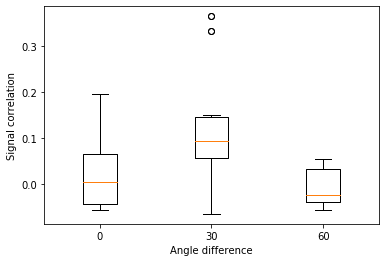

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=1)
data = []
for angle_dist, corrs in angle_dist_to_corrs.items():
    data.append(corrs)
ax.boxplot(data)
ax.set_xticklabels(['0', '30', '60', '90'])
ax.set_xlabel("Angle difference")
if corr_type == "TEMP_CORR_AVG":
    ax.set_ylabel("Signal correlation")
elif corr_type == "NOISE_CORR":
    ax.set_ylabel("Noise correlation")
#TODO: Just manually label the n's

for angle_dist, corrs in angle_dist_to_corrs.items():
    print(angle_dist, min(corrs), max(corrs), np.mean(corrs), np.std(corrs), len(corrs))

In [46]:
"""
Unused code that might be useful again someday
"""
"""
import seaborn as sns;
ser = pd.Series(list(dir_pairs_to_corrs.values()),
                  index=pd.MultiIndex.from_tuples(dir_pairs_to_corrs.keys()))
df = ser.unstack().fillna(0)
df = df.sort_index(axis=0 ,ascending=False)
sns.heatmap(df, center=0)

# For each angle, which angle groups are most correlated with it?
for dir1 in dirs:
    dir_partner_to_corr = {}
    for dir2 in dirs:
        key = (dir1, dir2)
        if key in dir_pairs_to_corrs:
            dir_partner_to_corr[dir2] = dir_pairs_to_corrs[key]
    desc_sorted_keys = sorted(dir_partner_to_corr, key=dir_partner_to_corr.get, reverse=True)
    print (dir1, desc_sorted_keys)
# The orderings are:
# For 501836392: [2,4,1,1,4,2,3], not bad, for a length of 8. mean ~2.43 ordering.
#   And.. that was when I was using allen dsi. When using our dsi, it got worse :(
# For 501886692: [6,5,7,2,2,3] - v bad
# For 501717543: [7,7,6,7,2] - v bad

"""
0

0